In [1]:
import numpy as np
from shapely import geometry
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the transport network.
## Saves a StepModel with air service links and nodes

In [2]:
input_path = '../input_static/public_transport/'
output_path = '../output/'
model_path = '../input_static/'

In [3]:
# Loading StepModel with pt network
sm = stepmodel.read_json(model_path + 'de_pt_network')

In [4]:
# Add air to the route types
route_type = 'air'
sm.pt_route_types.append(route_type)
prefix = route_type + '_'

### Add airports

In [5]:
sm.nodes.head(1)

,route_type,stop_name,geometry
index,,,
rail_long_node_1150,rail_long_distance,Aachen Hbf,POINT (6.09150 50.76780)


In [6]:
# Take only a selected set of airports equal to those of
# the Federal Government's transport study (Verkehrsverflechtungsprognose 2030)
airports = ['HAM', 'HAJ', 'BRE', 'FMO', 'PAD', 'NRN', 'DUS', 'DTM', 'CGN', 'FRA',
            'HHN', 'FKB', 'STR', 'FDH', 'NUE', 'MUC', 'SCN', 'TXL', 'SXF', 'LEJ',
            'DRS', 'ERF']

In [7]:
# Load list with airports
nodes = pd.read_csv(input_path + 'airports.csv', sep=';')
print(len(nodes.index))

7543


In [8]:
nodes.columns = ['ind', 'stop_name', 'city_name', 'country', 'code3', 'code4', 'lat', 'lon', '1', '2', '3', '4', '5']

In [9]:
# Filter for German nodes with ICAO only
nodes = nodes.loc[nodes['code3'].isin(airports)]
nodes.head(3)

,ind,stop_name,city_name,country,code3,code4,lat,lon,1,2,3,4,5
111,347,Airport Nürnberg,Nuernberg,Deutschland,NUE,EDDN,49.498699,11.078056,319,1.0,E,Europe/Berlin,"49.498699,11.078056"
117,349,Saarbrücken Airport,Saarbruecken,Deutschland,SCN,EDDR,49.214600,7.109510,322,1.0,E,Europe/Berlin,"49.2145996094,7.10950994492"
1349,382,Friedrichshafen Airport,Friedrichshafen,Deutschland,FDH,EDNY,47.671299,9.511490,417,1.0,E,Europe/Berlin,"47.6712989807,9.51148986816"


In [10]:
nodes['stop_name'] = nodes['code3'] + ', ' + nodes['stop_name']

In [11]:
nodes['route_type'] = route_type

In [12]:
nodes.set_index('code3', drop=True, inplace=True)

In [13]:
# Add geometry to nodes
nodes = gpd.GeoDataFrame(nodes[['stop_name', 'route_type']],
                         geometry=gpd.points_from_xy(nodes['lon'], nodes['lat']))
# Correct the coordinate reference system
nodes.crs = sm.epsg

In [14]:
nodes.head(3)

,stop_name,route_type,geometry
code3,,,
NUE,"NUE, Airport Nürnberg",air,POINT (11.07806 49.49870)
SCN,"SCN, Saarbrücken Airport",air,POINT (7.10951 49.21460)
FDH,"FDH, Friedrichshafen Airport",air,POINT (9.51149 47.67130)


<AxesSubplot:>

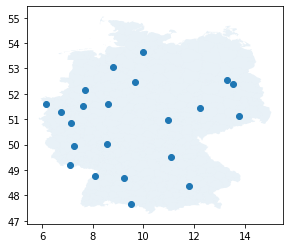

In [15]:
sm.zones = gpd.GeoDataFrame(sm.zones)
nodes['geometry'].plot(ax=sm.zones.plot(alpha=.1))

### Air links

In [16]:
sm.links.head(1)

,a,b,link_sequence,route_id,route_type,time,trip_id,geometry
index,,,,,,,,
rail_long_0,rail_long_node_1110,rail_long_node_630,1.0,rail_long_4,rail_long_distance,960.0,rail_long_1,"LINESTRING (7.46528 53.23165, 7.19518 53.36904)"


In [17]:
# Load the collection of airport interconnections within Germany
links = pd.read_excel(input_path + 'air_connections_germany.xlsx', engine='xlrd')

In [18]:
links = links.loc[links['direct']==True]
links.shape

(68, 7)

In [19]:
links['origin'] = links['origin'].str[:3]
links['destination'] = links['destination'].str[:3]

In [20]:
links.head()

,origin,destination,time,price_economy,price_business,airlines,direct
5,HAM,DUS,60.0,65.0,156.0,"Aegean Airlines, Air France, Austrian Airlines...",1.0
7,HAM,CGN,60.0,72.0,170.0,"Austrian Airlines, eurowings, Lufthansa, Ryana...",1.0
8,HAM,FRA,70.0,145.0,470.0,"Air France, Austrian Airlines, British Airways...",1.0
11,HAM,STR,75.0,82.0,183.0,"Aegean Airlines, Air France, Austrian Airlines...",1.0
13,HAM,NUE,65.0,73.0,155.0,"Austrian Airlines, eurowings, KLM, Lufthansa",1.0


In [21]:
# Add attributes
links['a'] = links['origin']
links['b'] = links['destination']
links['route_id'] = pd.Series([prefix + str(i) for i in range(len(links.index))],
                              index=links.index)
links['route_type'] = route_type
links['time'] = links['time'] * 60 # Convert to seconds
links['trip_id'] = links['a'] + '-' + links['b']
links['link_sequence'] = 1

In [22]:
# Add geometry column to links
lines = [geometry.LineString([nodes.loc[row['a'], 'geometry'], 
                             nodes.loc[row['b'], 'geometry']]) for _, row in links.iterrows()]
links = gpd.GeoDataFrame(links[sm.links.columns.drop('geometry')], geometry=lines)
links.crs = sm.epsg

In [23]:
links.set_index('route_id', drop=False, inplace=True)

In [24]:
links.loc[links['trip_id'].duplicated()]

,a,b,link_sequence,route_id,route_type,time,trip_id,geometry
route_id,,,,,,,,


In [25]:
links.head()

,a,b,link_sequence,route_id,route_type,time,trip_id,geometry
route_id,,,,,,,,
air_0,HAM,DUS,1,air_0,air,3600.0,HAM-DUS,"LINESTRING (9.98823 53.63040, 6.76678 51.28950)"
air_1,HAM,CGN,1,air_1,air,3600.0,HAM-CGN,"LINESTRING (9.98823 53.63040, 7.14274 50.86590)"
air_2,HAM,FRA,1,air_2,air,4200.0,HAM-FRA,"LINESTRING (9.98823 53.63040, 8.57056 50.03333)"
air_3,HAM,STR,1,air_3,air,4500.0,HAM-STR,"LINESTRING (9.98823 53.63040, 9.22196 48.68990)"
air_4,HAM,NUE,1,air_4,air,3900.0,HAM-NUE,"LINESTRING (9.98823 53.63040, 11.07806 49.49870)"


<AxesSubplot:>

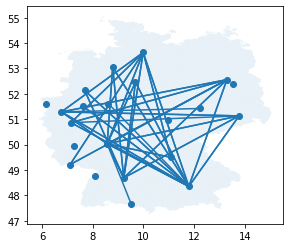

In [26]:
links['geometry'].plot(ax=nodes['geometry'].plot(ax=sm.zones.plot(alpha=.1)))

### Merge to StepModel

In [27]:
# Add links and nodes to stepmodel
sm.links = pd.concat([sm.links, links])
sm.nodes = pd.concat([sm.nodes, nodes])

In [28]:
sm.links.shape

(213129, 8)

In [29]:
# Add routes and agencies

In [30]:
len(sm.links['route_id'].unique())

681

### Save model


In [31]:
# Saving model...
sm.to_json(model_path + 'de_pt_network',
          only_attributes=['zones', 'links', 'nodes',
                           'agencies', 'pt_routes',
                           'pt_route_types', 'frequencies'],
          encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 37/37 [00:40<00:00,  1.08s/it]
